Первым шагом анализа датафрейма является общий анализ имеющихся данных. 
Видно, что датафрейм состоит из 39671 строк и нескольких столбцов.
При этом столбцы со временем дублируются (локальный временной пояс и стандартное время).
Очевидно, для анализа поведения имеет смысл использовать локальное время, к которому привязан пользователь,
а не абстрактное стандартное. Также столбцы Time Offset и User ID содержат всего одно значение
и не представляют интереса для анализа. Также видно, что данные по шагам разбросаны по времени в течение дня,
дни разбросаны по таблице.

Следующий шаг - определение критериев обычности/необычности. Что приходит в голову:

1. Самое естественное - количество шагов в день. 
Если оно сильно отличается от среднего, то скорее всего день можно отнести к разряду необычных
2. Второй возможный критерий - распределение активности в течение дня.
Например, если шагов было совершено среднее количество, но, например, имела место длительная ночная прогулка,
то вероятно день также может оказаться нетипичным
3. Менее очевидный критерий - средняя "скорость" 
(в качестве оной можно взять только количество шагов в секунду, так что показатель весьма косвенный) движения в течение дня.

На мой взгляд, это наиболее релевантные критерии для имеющегося набора данных.

Не имея тестовой выборки, невозможно построить какой-либо стандартный классификатор.
То есть, граница попадания в класс "обычных" или "необычных" дней определяется самим разработчиком,
а оценка точности построенной модели невозможна.

Начнём с создания промежуточного датафрейма, содержащего нужные нам для анализа данные. 
Я решил не удалять выбросы при расчёте статистики, так как датафрейм - совокупность реальных фактических данных.
В качестве контрольной временной отметки будем использовать дату начала отсчёта шагов.
В него запишем дату начала и время дня (в часах) каждой последовательности шагов, их количество,
и временную продолжительность последовательности. Видно, что всего в датафрейме есть информация по 104 дням. 
То есть, примерно по 400 записей за день. Можно сочитать количество шагов и среднюю скорость в каждый день. 
Если в качестве критерия обычности выбрать попадание в полосу среднеквадратичного отклонения, 
то получится 14 необычных дней по количеству шагов и 28 по скорости.

Если же посчитать информацию по распределению активности в течение дня, то оказывается,
что есть ещё 28 необычных дней по этому параметру. 
Понятно, что при  простом наложении всех трёх критериев получится слишком много необычных дней.

Как видно, дальнейшее уточнение критериев возможно только на интуитивном уровне. 
Основная идея, которую я решил развивать, разбить дни на безусловно необычные
(подбором параметров - примерно топ 5 по необычности в каждой из схем) с оценкой "2",
условно необычные (попадают в более узкую полосу вокруг среднего) с оценкой 1 и обычные с оценкой ноль.
Считая количество пройденных шагов наиболее объективным показателем
(это единтсвенное число, которое пользователь может сразу же непосредственно увидеть на смартфоне),
я сделал его приоритетным, расширив полосу необычности (2 при отдалении более, чем на 1.2ско, 0 при менее 1.05ско). 
Для остальных параметров я интуитивно ввёл более жёсткие критерии.
В идеале, при наличии оценки самого пользователя можно было бы построить регрессию.


Далее я просуммировал баллы и вывел результат в виде
1. необычный день, если сумма > 1
2. неизвестно, если сумма = 1
3. обычный, если сумма = 0

Как я показал, возможно есть смысл 
отдельно строить статистику для будних и выходных дней.

Готовая функция - в In38
Вслед за ней - готовый результат

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import datetime

In [2]:
#считываем датафрейм
df=pd.read_csv('D:/query.csv')
#смотрим, что он из себя представляет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39671 entries, 0 to 39670
Data columns (total 7 columns):
Time End               39671 non-null object
Time End Local Tz      39671 non-null object
Time Offset            39671 non-null int64
Time Start             39671 non-null object
Time Start Local Tz    39671 non-null object
User ID                39671 non-null int64
Value                  39671 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.1+ MB


In [3]:
#посмотрим первые 50 строчек
pd.set_option('display.max_rows', 200)
df.head(20)

,Time End,Time End Local Tz,Time Offset,Time Start,Time Start Local Tz,User ID,Value
0,2019-05-05T09:40:00+03:00,2019-05-05T12:40:00+03:00,10800,2019-05-05T09:39:59+03:00,2019-05-05T12:39:59+03:00,2166,1.0
1,2019-05-05T11:13:29+03:00,2019-05-05T14:13:29+03:00,10800,2019-05-05T11:12:51+03:00,2019-05-05T14:12:51+03:00,2166,34.0
2,2019-05-05T12:07:42+03:00,2019-05-05T15:07:42+03:00,10800,2019-05-05T12:07:39+03:00,2019-05-05T15:07:39+03:00,2166,1.0
3,2019-05-05T13:04:05+03:00,2019-05-05T16:04:05+03:00,10800,2019-05-05T13:04:02+03:00,2019-05-05T16:04:02+03:00,2166,3.0
4,2019-05-05T13:18:18+03:00,2019-05-05T16:18:18+03:00,10800,2019-05-05T13:18:13+03:00,2019-05-05T16:18:13+03:00,2166,6.0
5,2019-05-05T14:59:59+03:00,2019-05-05T17:59:59+03:00,10800,2019-05-05T14:58:09+03:00,2019-05-05T17:58:09+03:00,2166,77.0
6,2019-05-05T17:12:35+03:00,2019-05-05T20:12:35+03:00,10800,2019-05-05T17:11:36+03:00,2019-05-05T20:11:36+03:00,2166,61.0
7,2019-05-05T17:21:00+03:00,2019-05-05T20:21:00+03:00,10800,2019-05-05T17:20:06+03:00,2019-05-05T20:20:06+03:00,2166,69.0
8,2019-05-05T17:35:48+03:00,2019-05-05T20:35:48+03:00,10800,2019-05-05T17:35:36+03:00,2019-05-05T20:35:36+03:00,2166,17.0
9,2019-05-05T18:03:48+03:00,2019-05-05T21:03:48+03:00,10800,2019-05-05T18:03:41+03:00,2019-05-05T21:03:41+03:00,2166,9.0


In [4]:
#видно, что данные по дням разбросаны по разным записям и не отсортированы
df.sort_values(by='Time Start', ascending=True).head(100)

,Time End,Time End Local Tz,Time Offset,Time Start,Time Start Local Tz,User ID,Value
24172,2019-05-01T21:00:34+03:00,2019-05-02T00:00:34+03:00,10800,2019-05-01T21:00:00+03:00,2019-05-02T00:00:00+03:00,2166,16.0
24173,2019-05-01T21:00:39+03:00,2019-05-02T00:00:39+03:00,10800,2019-05-01T21:00:34+03:00,2019-05-02T00:00:34+03:00,2166,5.0
11540,2019-05-02T05:59:23+03:00,2019-05-02T08:59:23+03:00,10800,2019-05-02T05:50:00+03:00,2019-05-02T08:50:00+03:00,2166,8.0
11541,2019-05-02T05:59:59+03:00,2019-05-02T08:59:59+03:00,10800,2019-05-02T05:59:26+03:00,2019-05-02T08:59:26+03:00,2166,1.0
11542,2019-05-02T06:19:52+03:00,2019-05-02T09:19:52+03:00,10800,2019-05-02T06:10:00+03:00,2019-05-02T09:10:00+03:00,2166,8.0
11543,2019-05-02T06:19:55+03:00,2019-05-02T09:19:55+03:00,10800,2019-05-02T06:19:52+03:00,2019-05-02T09:19:52+03:00,2166,1.0
11544,2019-05-02T06:19:59+03:00,2019-05-02T09:19:59+03:00,10800,2019-05-02T06:19:55+03:00,2019-05-02T09:19:55+03:00,2166,1.0
11545,2019-05-02T06:33:31+03:00,2019-05-02T09:33:31+03:00,10800,2019-05-02T06:30:00+03:00,2019-05-02T09:30:00+03:00,2166,52.0
34724,2019-05-02T06:33:36+03:00,2019-05-02T09:33:36+03:00,10800,2019-05-02T06:33:31+03:00,2019-05-02T09:33:31+03:00,2166,3.0
11546,2019-05-02T06:34:35+03:00,2019-05-02T09:34:35+03:00,10800,2019-05-02T06:33:36+03:00,2019-05-02T09:33:36+03:00,2166,22.0


In [5]:
#создаём промежуточный датафрейм.
dfc=pd.DataFrame(columns = ['Date','Hour','Duration','Steps'])

#записываем дату, к которой относится последовательность шагов (дата начала отсчёта)
dfc['Date']=df['Time Start Local Tz'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S%z').date())

#записываем час, когда последовательность началась
dfc['Hour']=df['Time Start Local Tz'].apply(lambda y: datetime.datetime.strptime(y, '%Y-%m-%dT%H:%M:%S%z').time().hour)

#преобразуем столбцы исходного датафрейма во временной тип, вместо абстрактного non-null object
df['Time Start Local Tz'] = df['Time Start Local Tz'].astype('datetime64[ns]')
df['Time End Local Tz'] = df['Time End Local Tz'].astype('datetime64[ns]')

#записываем продолжительность последовательности в секундах
dfc['Duration']=df['Time End Local Tz']-df['Time Start Local Tz']
dfc['Duration']=dfc['Duration'].transform(lambda x: x.seconds)

#записываем шаги
dfc['Steps']=df['Value'].apply(lambda x: int(x))

#смотрим, что получилось
dfc.info()
dfc.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39671 entries, 0 to 39670
Data columns (total 4 columns):
Date        39671 non-null object
Hour        39671 non-null int64
Duration    39671 non-null int64
Steps       39671 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.2+ MB


,Date,Hour,Duration,Steps
0,2019-05-05,12,1,1
1,2019-05-05,14,38,34
2,2019-05-05,15,3,1
3,2019-05-05,16,3,3
4,2019-05-05,16,5,6
5,2019-05-05,17,110,77
6,2019-05-05,20,59,61
7,2019-05-05,20,54,69
8,2019-05-05,20,12,17
9,2019-05-05,21,7,9


In [6]:
#проанализируем количество шагов в день. Для этого создадим датафрейм
sumsteps=pd.DataFrame(columns = ['Date','Total Steps','Average Velocity','Steps Amount Result','Average Velocity Result','Time Distribution Result'])

#запишем в енго все дни, когда были сделаны записи
sumsteps['Date']=dfc['Date'].drop_duplicates()
sumsteps=sumsteps.sort_values(by='Date', ascending=True).reset_index(drop=True)

#суммируем шаги и продолжительность активности по дням
for i in range(len(sumsteps)):
    sumsteps.loc[i, 'Total Steps'] = dfc[(dfc['Date']==sumsteps['Date'][i])]['Steps'].sum()
    sumsteps.loc[i, 'Average Velocity'] = sumsteps.loc[i, 'Total Steps']/dfc[(dfc['Date']==sumsteps['Date'][i])]['Duration'].sum()
#сделаем копию
temp=sumsteps.copy()
#смотрим, что получилось
sumsteps.head(20)
#sumsteps.info()

,Date,Total Steps,Average Velocity,Steps Amount Result,Average Velocity Result,Time Distribution Result
0,2019-05-02,12977,0.641981,NaN,NaN,NaN
1,2019-05-03,17003,0.88821,NaN,NaN,NaN
2,2019-05-04,14312,1.01088,NaN,NaN,NaN
3,2019-05-05,11124,0.463945,NaN,NaN,NaN
4,2019-05-06,7467,0.584959,NaN,NaN,NaN
5,2019-05-07,9027,0.643866,NaN,NaN,NaN
6,2019-05-08,12888,0.645562,NaN,NaN,NaN
7,2019-05-09,12982,0.809554,NaN,NaN,NaN
8,2019-05-10,26759,1.06444,NaN,NaN,NaN
9,2019-05-11,13047,0.652089,NaN,NaN,NaN


In [7]:
#подготовим построение графиков
#%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
plt.plot(sumsteps['Date'],sumsteps['Total Steps'])
plt.xticks(rotation=90) 
plt.xlabel('date')
plt.ylabel('steps')
plt.title('steps statistics')
#график показывает, что количество шагов колеблется около некоторого среднего за редким исключением

D:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'steps statistics')

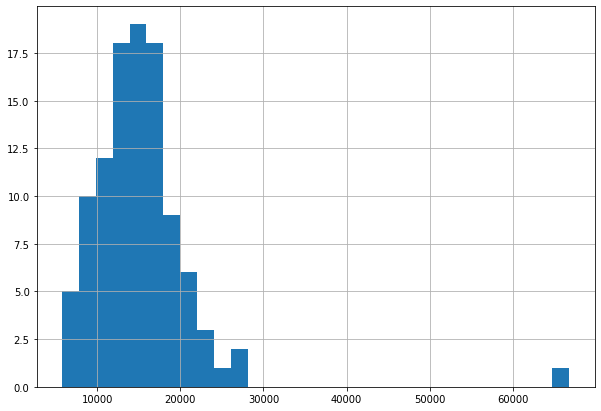

In [8]:
#построим гистограмму распределения количества шагов
sumsteps['Total Steps'].hist(figsize=(10,7), bins=30)

In [9]:
#посмотрим на основные характеристики распределения
m=sumsteps['Total Steps'].mean()
st=sumsteps['Total Steps'].std()
print('среднее:', '{0:.0f}'.format(m))
print('минимум:', '{0:.0f}'.format(sumsteps['Total Steps'].min()))
print('максимум:', '{0:.0f}'.format(sumsteps['Total Steps'].max()))
print('скв отклонение:', '{0:.0f}'.format(st))

среднее: 15234
минимум: 5776
максимум: 66761
скв отклонение: 6683


In [10]:
#на всякий случай убедимся, что оно не нормальное
from scipy.stats import shapiro
shapiro(sumsteps['Total Steps'])

(0.6724650263786316, 6.633960687642965e-14)

In [11]:
#осталось подобрать параметры определяющие, относится ли день к обычному или нет
#параметр a - коэффициент, на который умножается стандартное отклонение, им регулируется ширина полосы вокруг среднего
#предварительно обычным будет день попадающий в полосу
a=1
st=a*st
sumsteps['Steps Amount Result'] = sumsteps['Total Steps'].transform(lambda x: 1 if (x>m+st) or (x<m-st) else 0)
sumsteps[(sumsteps['Steps Amount Result']==1)].count()

Date                        14
Total Steps                 14
Average Velocity            14
Steps Amount Result         14
Average Velocity Result      0
Time Distribution Result     0
dtype: int64

(array([737180., 737194., 737211., 737225., 737241., 737255., 737272.,
        737286.]), <a list of 8 Text xticklabel objects>)

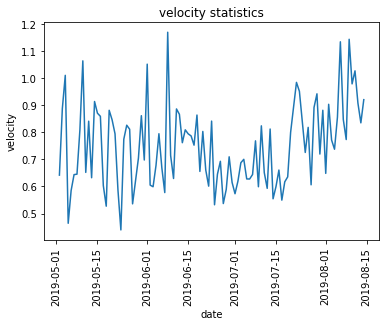

In [12]:
#если в качестве критерия выбрать попадание количества шагов в среднее плюс минус среднеквадратичное отклонение, получаем
#что необычными являются 14 дней, то есть примерно один день в неделю. Пока оставим так.
#Провернём то же со скоростью
plt.plot(sumsteps['Date'],sumsteps['Average Velocity'])
plt.xlabel('date')
plt.ylabel('velocity')
plt.title('velocity statistics')
plt.xticks(rotation=90) 


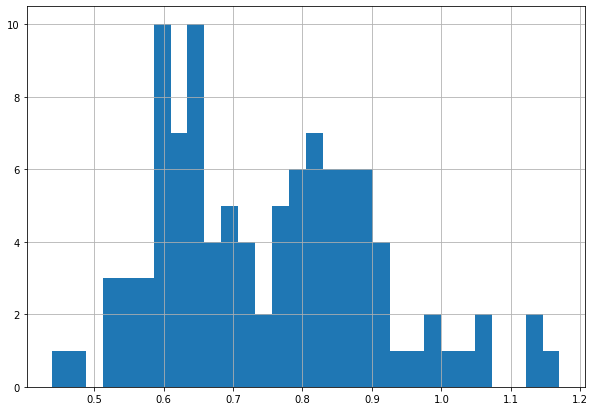

In [13]:
sumsteps['Average Velocity'].hist(figsize=(10,7), bins=30)

In [14]:
shapiro(sumsteps['Average Velocity'])
#тоже не гауссово

(0.9692157506942749, 0.01591010019183159)

In [15]:
#посмотрим на основные характеристики распределения
m1=sumsteps['Average Velocity'].mean()
st1=sumsteps['Average Velocity'].std()
print('среднее:', '{0:.3f}'.format(m1))
print('минимум:', '{0:.3f}'.format(sumsteps['Average Velocity'].min()))
print('максимум:', '{0:.3f}'.format(sumsteps['Average Velocity'].max()))
print('скв отклонение:', '{0:.3f}'.format(st1))

среднее: 0.752
минимум: 0.439
максимум: 1.170
скв отклонение: 0.153


In [16]:
#воспользуемся тем же скв отклонением - получим слишком много дней - 28
#параметр b также регулирует ширину полосы обычности
b=1
st1=b*st1
sumsteps['Average Velocity Result'] = sumsteps['Average Velocity'].transform(lambda x: 1 if (x>m1+st1) or (x<m1-st1) else 0)
sumsteps[(sumsteps['Average Velocity Result']==1)].count()

Date                        28
Total Steps                 28
Average Velocity            28
Steps Amount Result         28
Average Velocity Result     28
Time Distribution Result     0
dtype: int64

In [17]:
sumsteps.head(len(sumsteps))

,Date,Total Steps,Average Velocity,Steps Amount Result,Average Velocity Result,Time Distribution Result
0,2019-05-02,12977,0.641981,0,0,NaN
1,2019-05-03,17003,0.88821,0,0,NaN
2,2019-05-04,14312,1.01088,0,1,NaN
3,2019-05-05,11124,0.463945,0,1,NaN
4,2019-05-06,7467,0.584959,1,1,NaN
5,2019-05-07,9027,0.643866,0,0,NaN
6,2019-05-08,12888,0.645562,0,0,NaN
7,2019-05-09,12982,0.809554,0,0,NaN
8,2019-05-10,26759,1.06444,1,1,NaN
9,2019-05-11,13047,0.652089,0,0,NaN


In [18]:
#пока что оставим так
#проведём анализ поведения в течение дня
#создадим одномерный массиы aver, содержащий все часы(0-23), по которым есть хоть одна запись
aver=dfc['Hour'].drop_duplicates()
aver=aver.sort_values(ascending=True).reset_index(drop=True)
print(aver)

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
Name: Hour, dtype: int64


In [19]:
#Видно, что записи есть по всем часам
#создадим массив. В этот массив для каждого дня будет записан процент шагов, 
#который был пройден в каждый час по отношению к общему количеству шагов в данный день
#создадим массив stat с шагами(столбцы) по часам за каждый день(строки)
stat=np.zeros([len(sumsteps),len(aver)],dtype=float)
for i in range(len(sumsteps)):
    for j in range(len(aver)):
        stat[i][j]=dfc[((dfc['Date']==sumsteps['Date'][i]) & (dfc['Hour']==aver[j]))]['Steps'].sum()
print(stat)

[[2.100e+01 0.000e+00 0.000e+00 ... 0.000e+00 1.061e+03 3.000e+01]
 [0.000e+00 0.000e+00 0.000e+00 ... 3.057e+03 1.700e+01 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 1.540e+02 5.650e+02 0.000e+00]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 3.478e+03 1.872e+03 2.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 6.800e+01 6.100e+01 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]


In [20]:
#перейдём к процентам (точнее - долям), просуммировав построчно шаги, и поделив на них количесвто шагов в данный час (построчно)
norm=np.zeros([len(sumsteps)],dtype=float)
for i in range(len(sumsteps)):
    norm[i]=stat[i].sum()        
for i in range(len(sumsteps)):
    stat[i]=stat[i]/norm[i]
    
#массив со средними значениями почасовой активности  
dschnitt=stat.mean(axis=0)
print(dschnitt)

[0.01535917 0.01077519 0.00058707 0.00084822 0.00059493 0.00120513
 0.00078911 0.00206864 0.01888792 0.05449484 0.04942847 0.04800251
 0.06007177 0.0627976  0.0657143  0.06508152 0.06374404 0.06325287
 0.06227384 0.07482702 0.07903953 0.07880499 0.08719651 0.03415483]


Text(0.5, 1.0, 'activity statistics')

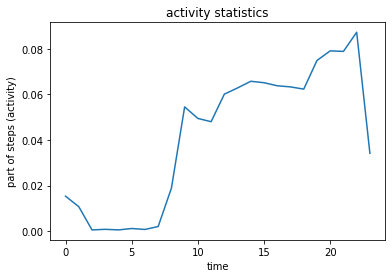

In [21]:
#график средней активности по доле шагов в течение дня
plt.plot(aver, dschnitt)
plt.xlabel('time')
plt.ylabel('part of steps (activity)')
plt.title('activity statistics')

In [22]:
#из графика видно, что ночью пользователь спал. Днём его двигательная активность распределена более или менее равномерно 
#(возможно у него работа связана с умеренными периодическими переходами в офисном пространстве)
#осносвной период активности - вечером. Складывается вполне нормальная картина
#для каждого дня вычислим, насколько распределение отличается от среднего
#в ddist запишем отклонение распределения шагов в данный день от среднего
import math
ddist=np.zeros([len(sumsteps)])
for i in range(len(sumsteps)):
    z=0
    for j in range(len(dschnitt)):
        z+=(stat[i][j]-dschnitt[j])**2
    ddist[i]=math.sqrt(z/(len(dschnitt)-1))

In [23]:
#добавим результат в нашу таблицу
#c - регулирует ширину полосы обычности
с=1
p=с*ddist.std()
q=ddist.mean()
for i in range(len(ddist)):
    if (ddist[i] < (q-p) or ddist[i] > (q+p)):
        sumsteps['Time Distribution Result'][i] = 1
    else:
        sumsteps['Time Distribution Result'][i] = 0
sumsteps[(sumsteps['Time Distribution Result']==1)].count()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Date                        28
Total Steps                 28
Average Velocity            28
Steps Amount Result         28
Average Velocity Result     28
Time Distribution Result    28
dtype: int64

In [24]:
sumsteps.head(104)

,Date,Total Steps,Average Velocity,Steps Amount Result,Average Velocity Result,Time Distribution Result
0,2019-05-02,12977,0.641981,0,0,0
1,2019-05-03,17003,0.88821,0,0,0
2,2019-05-04,14312,1.01088,0,1,1
3,2019-05-05,11124,0.463945,0,1,0
4,2019-05-06,7467,0.584959,1,1,0
5,2019-05-07,9027,0.643866,0,0,0
6,2019-05-08,12888,0.645562,0,0,1
7,2019-05-09,12982,0.809554,0,0,1
8,2019-05-10,26759,1.06444,1,1,0
9,2019-05-11,13047,0.652089,0,0,0


In [25]:
#очевидно, что стандартное отклонение не годится на роль границы обычности, так как слишком много дней становятся необычными
#я предположил, что количество необычных дней должно составлять 10-15% от общего количества. Ещё 10% можно отнести
#к пограничным ("unknown"). Также хотелось бы учесть все три подхода с предпочтительным - количеством шагов.
#Я делал ручной подбор параметров. Кроме того, пришлось ввести дополнительные параметры a1,b1,c1, которые регулируют ширину
#полосы попадания дней в разряд условно необычных

In [26]:
#посмотрим, что получилось. Заполним результаты в соответствии с выбранным подходом
sumsteps=temp.copy()
sumsteps.head()

,Date,Total Steps,Average Velocity,Steps Amount Result,Average Velocity Result,Time Distribution Result
0,2019-05-02,12977,0.641981,NaN,NaN,NaN
1,2019-05-03,17003,0.88821,NaN,NaN,NaN
2,2019-05-04,14312,1.01088,NaN,NaN,NaN
3,2019-05-05,11124,0.463945,NaN,NaN,NaN
4,2019-05-06,7467,0.584959,NaN,NaN,NaN


условные:  4
безусловные:  7


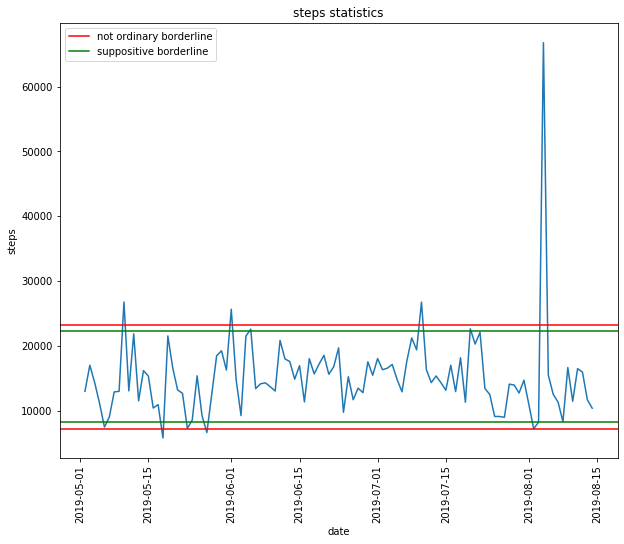

In [27]:
#начнём с количества шагов в день
#здесь я указал значения параметров, определяющих, относится ли день к безусловно необычному - a (2 балла) или подозрительному - a1
a=1.2
a1=1.05
sumsteps['Steps Amount Result'] = sumsteps['Total Steps'].transform(lambda x: 2 if (x>m+a*st) or (x<m-a*st) else (1 if (x>m+a1*st) or (x<m-a1*st)  else 0))
#условные
print('условные: ',sumsteps[(sumsteps['Steps Amount Result']==1)]['Date'].count())
#безусловные
print('безусловные: ',sumsteps[(sumsteps['Steps Amount Result']==2)]['Date'].count())
#получим 7 необычных дней и 4 подозрительных
#указанные выше значения параметров будем использовать в функции по умолчанию
rcParams['figure.figsize'] = 10, 8
plt.plot(sumsteps['Date'],sumsteps['Total Steps'])
plt.xticks(rotation=90) 
plt.xlabel('date')
plt.ylabel('steps')
plt.title('steps statistics')
plt.axhline(y=m+a*st, color='r', linestyle='-', label='not ordinary borderline')
plt.axhline(y=m-a*st, color='r', linestyle='-')
plt.axhline(y=m+a1*st, color='g', linestyle='-', label='suppositive borderline')
plt.axhline(y=m-a1*st, color='g', linestyle='-')
plt.legend()


условные:  5
безусловные:  3


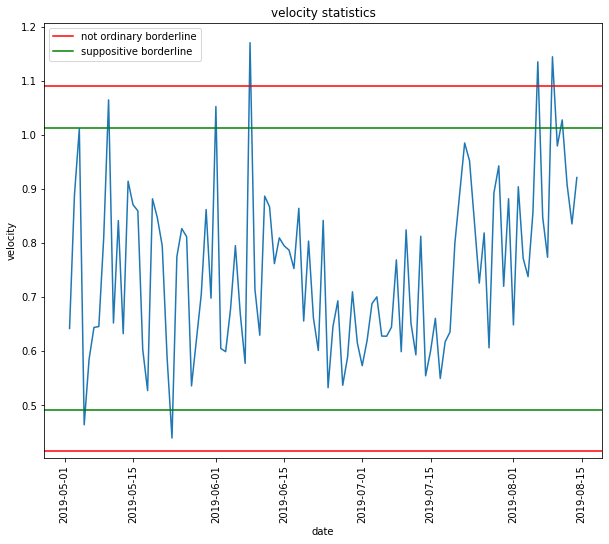

In [28]:
#проделаем то же для распределения активности по часам дня
b=2.2
b1=1.7
sumsteps['Average Velocity Result'] = sumsteps['Average Velocity'].transform(lambda x: 2 if (x>m1+b*st1) or (x<m1-b*st1) else (1 if (x>m1+b1*st1) or (x<m1-b1*st1) else 0))
#условные
print('условные: ',sumsteps[(sumsteps['Average Velocity Result']==1)]['Date'].count())
#безусловные
print('безусловные: ',sumsteps[(sumsteps['Average Velocity Result']==2)]['Date'].count())
plt.plot(sumsteps['Date'],sumsteps['Average Velocity'])
plt.xlabel('date')
plt.ylabel('velocity')
plt.title('velocity statistics')
plt.xticks(rotation=90)
plt.axhline(y=m1+b*st1, color='r', linestyle='-', label='not ordinary borderline')
plt.axhline(y=m1-b*st1, color='r', linestyle='-')
plt.axhline(y=m1+b1*st1, color='g', linestyle='-', label='suppositive borderline')
plt.axhline(y=m1-b1*st1, color='g', linestyle='-')
plt.legend()


In [29]:
#и со средней скоростью
c=2.2
c1=1.7
p=ddist.std()
q=ddist.mean()
for i in range(len(ddist)):
    if (ddist[i] < (q-c*p) or ddist[i] > (q+c*p)):
        sumsteps['Time Distribution Result'][i] = 2
    elif (ddist[i] < (q-c1*p) or ddist[i] > (q+c1*p)):
        sumsteps['Time Distribution Result'][i] = 1
    else:
        sumsteps['Time Distribution Result'][i] = 0
#условные
print('условные: ',sumsteps[(sumsteps['Time Distribution Result']==1)]['Date'].count())
#безусловные
print('безусловные: ',sumsteps[(sumsteps['Time Distribution Result']==2)]['Date'].count())

условные:  2
безусловные:  4


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1]:
sumsteps.head(len(sumsteps))
rcParams['figure.figsize'] = 6, 4
plt.plot(aver, stat[16])
plt.xlabel('time')
plt.ylabel('activity')
plt.title('activity statistics')

NameError: name 'sumsteps' is not defined

In [ ]:
sumsteps.head(len(sumsteps))
rcParams['figure.figsize'] = 6, 4
plt.plot(aver, stat[16])
plt.xlabel('time')
plt.ylabel('activity')
plt.title('activity statistics')

Text(0.5, 1.0, 'activity statistics')

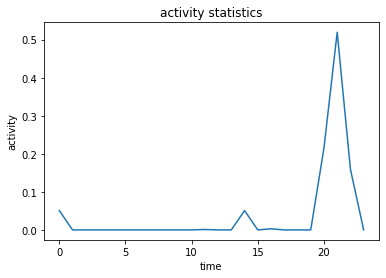

In [31]:
#ради интереса: пример активности в день 2019-06-08, когда шагов среднее количество, но период активности и скорость необычные
#скорее всего, пользователь целый день практически не двигался, но вечером совершил одну длинную прогулку
#день попадает в категорию необычных
rcParams['figure.figsize'] = 6, 4
plt.plot(aver, stat[36])
plt.xlabel('time')
plt.ylabel('activity')
plt.title('activity statistics')

In [32]:
#суммируем баллы, классифицируем дни
sumsteps['Result']=sumsteps['Time Distribution Result']+sumsteps['Average Velocity Result']+sumsteps['Steps Amount Result']
sumsteps['Result']=sumsteps['Result'].transform(lambda x: 'not ordinary' if x>1 else ('ordinary' if x==0 else 'unknown'))


In [33]:
#для дальнейшего анализа отметим выходные и будние дни (без учёта праздников)
sumsteps['Day Type']=sumsteps['Date'].transform(lambda x: 'day off' if (datetime.datetime.isoweekday(x)==7) | (datetime.datetime.isoweekday(x)==6) else 'work day')

In [34]:
sumsteps.head(10)

,Date,Total Steps,Average Velocity,Steps Amount Result,Average Velocity Result,Time Distribution Result,Result,Day Type
0,2019-05-02,12977,0.641981,0,0,0,ordinary,work day
1,2019-05-03,17003,0.88821,0,0,0,ordinary,work day
2,2019-05-04,14312,1.01088,0,0,1,unknown,day off
3,2019-05-05,11124,0.463945,0,1,0,unknown,day off
4,2019-05-06,7467,0.584959,1,0,0,unknown,work day
5,2019-05-07,9027,0.643866,0,0,0,ordinary,work day
6,2019-05-08,12888,0.645562,0,0,0,ordinary,work day
7,2019-05-09,12982,0.809554,0,0,0,ordinary,work day
8,2019-05-10,26759,1.06444,2,1,0,not ordinary,work day
9,2019-05-11,13047,0.652089,0,0,0,ordinary,day off


In [35]:
#сосчитаем, что получилось
d=sumsteps[(sumsteps['Result']=='ordinary')]['Date'].count()
d1=sumsteps[(sumsteps['Result']=='ordinary') & (sumsteps['Day Type']=='day off')]['Date'].count()
f=sumsteps[(sumsteps['Result']=='unknown')]['Date'].count()
f1=sumsteps[(sumsteps['Result']=='unknown') & (sumsteps['Day Type']=='day off')]['Date'].count()
g=sumsteps[(sumsteps['Result']=='not ordinary')]['Date'].count()
g1=sumsteps[(sumsteps['Result']=='not ordinary') & (sumsteps['Day Type']=='day off')]['Date'].count()
print('обычные дни: \t\t',d,'\t', '{0:.1f}%'.format(100*d/len(sumsteps)))
print('из них выходные: \t',d1)
print('\nнеопределённые дни: \t',f,'\t', '{0:.1f}%'.format(100*f/len(sumsteps)))
print('из них выходные: \t',f1)
print('\nнеобычные дни: \t\t',g,'\t', '{0:.1f}%'.format(100*g/len(sumsteps)))
print('из них выходные: \t',g1)
#получаем итуитивно разумный результат

обычные дни: 		 84 	 80.8%
из них выходные: 	 20

неопределённые дни: 	 7 	 6.7%
из них выходные: 	 5

необычные дни: 		 13 	 12.5%
из них выходные: 	 5


In [36]:
#видно, что в целом выходные дни имеют тенденцию быть необычными. Не в последнюю очередь по причине другого распределения 
#активности по времени и возможности провести день дома или наоборот, сделать его активным
#другой вопрос, как сам пользователь интерпретирует результат: "я провёл выходной дома и это обычно" или
#"я просидел выходной дома, мало двигался, для меня это в целом нетипично"
#для полноты картины возможно стоило учитывать не только выходные, но и праздничные и предпраздничные дни, однако 
#я оставил это за рамками анализа
#также 104 дня (всего около 30 выходных) - относительно небольшой датасет, чтобы разбивать его на доли
#я также не стал делать отдельный анализ по рабочим/нерабочим дням. Однако надо иметь в виду, что такое разделение 
#очевидно не бессмысленно

#выкинем лишние столбцы для получение результата
sumsteps.drop(['Total Steps', 'Average Velocity','Steps Amount Result','Average Velocity Result','Time Distribution Result', 'Day Type'], axis='columns', inplace=True)
sumsteps.head(len(sumsteps))

,Date,Result
0,2019-05-02,ordinary
1,2019-05-03,ordinary
2,2019-05-04,unknown
3,2019-05-05,unknown
4,2019-05-06,unknown
5,2019-05-07,ordinary
6,2019-05-08,ordinary
7,2019-05-09,ordinary
8,2019-05-10,not ordinary
9,2019-05-11,ordinary


In [37]:
#Теперь можно составить функцию

In [38]:
import pandas as pd
import numpy as np
import datetime
import math
import warnings
warnings.filterwarnings("ignore")
    
    
def day_type(path,a=1.2,a1=1.05,b=2.2,b1=1.7,c=2.2,c1=1.7):
    
    """
    Makes the dataframe containing the day classification. 
    
    Parameters
    ----------
    path - path to dataframe. The Dataframe should contain columns 'Time End', 'Time End Local Tz', 'Time Offset',
    'Time Start', 'Time Start Local Tz', 'User ID', 'Value'. Time columns are in '%Y-%m-%dT%H:%M:%S%z' format.
    
    a - factor by what the standard deviation is multiplied to defy the width of band
    around the average value of steps (per day) outside which the values are supposed to be not ordinary
    
    a1 - factor by what the standard deviation is multiplied to defy the width of band
    around the average value of steps (per day) inside which the values are supposed to be ordinary
        values between these two boards are supposed to be suppositive
        
    b - factor by what the standard deviation is multiplied to defy the width of band
    around the average velocity (during the day) outside which the values are supposed to be not ordinary
    
    b1 - factor by what the standard deviation is multiplied to defy the width of band
    around the average velocity (during the day) inside which the values are supposed to be ordinary
        values between these two boards are supposed to be suppositive
    
    c - factor by what the standard deviation is multiplied to defy the width of band
    around the average activity distribution (during the day) outside which the values are supposed to be not ordinary
    
    c1 - factor by what the standard deviation is multiplied to defy the width of band
    around the average activity distribution (during the day) inside which the values are supposed to be ordinary
        values between these two boards are supposed to be suppositive
     
    default values a=1.2, a1=1.05, b=2.2, b1=1.7, c=2.2, c1=1.7
    
    
    Returns
    ----------
    Dataframe containing three columns:
    Date - in '%Y-%m-%d format
    Total Steps - amount of steps per day
    Result - 'ordinary', 'not ordinary', 'unknown'
    
    
    Example
    ----------
    a=day_type(r'D:/query.csv')
    
    """
    
    df=pd.read_csv(path)
    #создаём промежуточный датафрейм.
    dfc=pd.DataFrame(columns = ['Date','Hour','Duration','Steps'])

    #записываем дату, к которой относится последовательность шагов (дата начала отсчёта)
    dfc['Date']=df['Time Start Local Tz'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S%z').date())

    #записываем час, когда последовательность началась
    dfc['Hour']=df['Time Start Local Tz'].apply(lambda y: datetime.datetime.strptime(y, '%Y-%m-%dT%H:%M:%S%z').time().hour)

    #преобразуем столбцы исходного датафрейма во временной тип, вместо абстрактного non-null object
    df['Time Start Local Tz'] = df['Time Start Local Tz'].astype('datetime64[ns]')
    df['Time End Local Tz'] = df['Time End Local Tz'].astype('datetime64[ns]')

    #записываем продолжительность последовательности в секундах
    dfc['Duration']=df['Time End Local Tz']-df['Time Start Local Tz']
    dfc['Duration']=dfc['Duration'].transform(lambda x: x.seconds)

    #записываем шаги
    dfc['Steps']=df['Value'].apply(lambda x: int(x))
    #проанализируем количество шагов в день. Для этого создадим датафрейм

    sumsteps=pd.DataFrame(columns = ['Date','Total Steps','Average Velocity','Steps Amount Result','Average Velocity Result','Time Distribution Result'])

    #запишем в него все дни, когда были сделаны записи
    sumsteps['Date']=dfc['Date'].drop_duplicates()
    sumsteps=sumsteps.sort_values(by='Date', ascending=True).reset_index(drop=True)

    #суммируем шаги и продолжительность активности по дням
    for i in range(len(sumsteps)):
        sumsteps.loc[i, 'Total Steps'] = dfc[(dfc['Date']==sumsteps['Date'][i])]['Steps'].sum()
        sumsteps.loc[i, 'Average Velocity'] = sumsteps.loc[i, 'Total Steps']/dfc[(dfc['Date']==sumsteps['Date'][i])]['Duration'].sum()
    
    #находим средние и отклонения
    m=sumsteps['Total Steps'].mean()
    st=sumsteps['Total Steps'].std()
    m1=sumsteps['Average Velocity'].mean()
    st1=sumsteps['Average Velocity'].std()
    
    #заполняем
    sumsteps['Steps Amount Result'] = sumsteps['Total Steps'].transform(lambda x: 2 if (x>m+a*st) or (x<m-a*st) else (1 if (x>m+a1*st) or (x<m-a1*st)  else 0))
    sumsteps['Average Velocity Result'] = sumsteps['Average Velocity'].transform(lambda x: 2 if (x>m1+b*st1) or (x<m1-b*st1) else (1 if (x>m1+b1*st1) or (x<m1-b1*st1) else 0))

    #создадим одномерный массиы aver, содержащий все часы(0-23), по которым есть хоть одна запись
    aver=dfc['Hour'].drop_duplicates()
    aver=aver.sort_values(ascending=True).reset_index(drop=True)
    
    #создадим массив stat с шагами(столбцы) по часам за каждый день(строки)
    stat=np.zeros([len(sumsteps),len(aver)],dtype=float)
    for i in range(len(sumsteps)):
        for j in range(len(aver)):
            stat[i][j]=dfc[((dfc['Date']==sumsteps['Date'][i]) & (dfc['Hour']==aver[j]))]['Steps'].sum()
    
    #перейдём к процентам (точнее - долям), просуммировав построчно шаги, и поделив на них количесвто шагов в данный час (построчно)
    norm=np.zeros([len(sumsteps)],dtype=float)
    for i in range(len(sumsteps)):
        norm[i]=stat[i].sum()        
    for i in range(len(sumsteps)):
        stat[i]=stat[i]/norm[i]
    
    #массив со средними значениями почасовой активности  
    dschnitt=stat.mean(axis=0)
    
    #в ddist запишем отклонение распределения шагов в данный день от среднего
    ddist=np.zeros([len(sumsteps)])
    for i in range(len(sumsteps)):
        z=0
        for j in range(len(dschnitt)):
            z+=(stat[i][j]-dschnitt[j])**2
        ddist[i]=math.sqrt(z/(len(dschnitt)-1))
    p=ddist.std()
    q=ddist.mean()
    for i in range(len(ddist)):
        if (ddist[i] < (q-c*p) or ddist[i] > (q+c*p)):
            sumsteps['Time Distribution Result'][i] = 2
        elif (ddist[i] < (q-c1*p) or ddist[i] > (q+c1*p)):
            sumsteps['Time Distribution Result'][i] = 1
        else:
            sumsteps['Time Distribution Result'][i] = 0
    
    #суммируем баллы, классифицируем дни
    sumsteps['Result']=sumsteps['Time Distribution Result']+sumsteps['Average Velocity Result']+sumsteps['Steps Amount Result']
    sumsteps['Result']=sumsteps['Result'].transform(lambda x: 'not ordinary' if x>1 else ('ordinary' if x==0 else 'unknown'))

    #выкинем лишние столбцы для получение результата
    sumsteps.drop(['Average Velocity','Steps Amount Result','Average Velocity Result','Time Distribution Result'], axis='columns', inplace=True)

    return sumsteps




In [39]:
pd.set_option('display.max_rows', 200)
a=day_type(r'D:/query.csv')
a.head(len(a))


,Date,Total Steps,Result
0,2019-05-02,12977,ordinary
1,2019-05-03,17003,ordinary
2,2019-05-04,14312,unknown
3,2019-05-05,11124,unknown
4,2019-05-06,7467,unknown
5,2019-05-07,9027,ordinary
6,2019-05-08,12888,ordinary
7,2019-05-09,12982,ordinary
8,2019-05-10,26759,not ordinary
9,2019-05-11,13047,ordinary


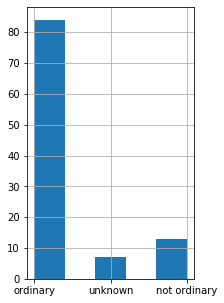

In [40]:
a['Result'].hist(figsize=(3,5), bins=5)